In [2]:
# Dataset : https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction

In [3]:
import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE 

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.inspection import permutation_importance

In [4]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style('whitegrid')
sns.color_palette('dark')
# plt.style.use('fivethirtyeight')
plt.style.use('seaborn')

## Load Dataset

In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [6]:
# Load application record
df_application_rec = pd.read_csv('D://Bootcamp//Dibimbing//== FINAL PROJECT ==//Dataset//Kaggle - Credit Card Approval//application_record.csv')
# df_application_rec = pd.read_csv('/content/gdrive/MyDrive/DatasetFinalProjectDibimbing/application_record.csv')
df_application_rec.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [7]:
df_application_rec.shape

(438557, 18)

In [8]:
# Load Credit Record
df_credit_rec = pd.read_csv('D://Bootcamp//Dibimbing//== FINAL PROJECT ==//Dataset//Kaggle - Credit Card Approval//credit_record.csv')
# df_credit_rec = pd.read_csv('/content/gdrive/MyDrive/DatasetFinalProjectDibimbing/credit_record.csv')

In [9]:
df_credit_rec.shape

(1048575, 3)

In [10]:
df_credit_rec.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [11]:
# Months *-1 so it won't be negative since we already know what it means
# Sort Data by ID and Months reverse
df_credit_rec['months_reverse'] = df_credit_rec['MONTHS_BALANCE']*-1
df_credit_rec = df_credit_rec.sort_values(['ID','months_reverse'], ascending=True)
df_credit_rec = df_credit_rec.drop('MONTHS_BALANCE', axis=1)
df_credit_rec = df_credit_rec.rename(columns={'months_reverse': 'MONTHS_BALANCE'})

# Group by ID
df_credit_rec = df_credit_rec.groupby('ID').agg(max).reset_index()

df_credit_rec.head(5)

,ID,STATUS,MONTHS_BALANCE
0,5001711,X,3
1,5001712,C,18
2,5001713,X,21
3,5001714,X,14
4,5001715,X,59


In [12]:
# Join two csv
final_df = df_application_rec.merge(df_credit_rec, on=['ID'], how='inner')

In [13]:
final_df.head(3)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS,MONTHS_BALANCE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,X,15
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,X,14
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,X,29


In [14]:
final_df.shape

(36457, 20)

## Data Preprocessing

### Encoding

In [15]:
final_df['CODE_GENDER'].replace(['F','M'], [0,1],inplace=True)
final_df['FLAG_OWN_CAR'].replace(['Y','N'], [1,0],inplace=True)
final_df['FLAG_OWN_REALTY'].replace(['Y','N'], [1,0],inplace=True)

In [16]:
final_df['STATUS'].unique()

array(['X', '0', '1', 'C', '3', '5', '2', '4'], dtype=object)

In [17]:
# Gabungkan C dan X menjadi  0 (1-29 days past due), karena kurang lebih berarti no loan/paid
final_df['STATUS'].replace(['C','X'], [0,0],inplace=True)
final_df['STATUS'].unique()

array([0, '0', '1', '3', '5', '2', '4'], dtype=object)

In [18]:
# replace the value C and X with 0 as it is the same type
# 1,2,3,4,5 are classified as 1 because they are the same type
# these will be our labels/prediction results for our model
final_df['STATUS'] = final_df['STATUS'].astype('int')
final_df['STATUS'] = final_df['STATUS'].apply(lambda x:1 if x >= 2 else 0)

In [19]:
# We found days_birth and days_employed
# To make it make sense, we will divide the days by 365 and take the value as year

final_df['age']=-(final_df['DAYS_BIRTH'])//365
final_df['years_employed']=-(final_df['DAYS_EMPLOYED'])//365

final_df.drop(columns=('DAYS_BIRTH'), inplace=True)
final_df.drop(columns=('DAYS_EMPLOYED'), inplace=True)

### Check Missing Value

In [20]:
final_df.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS,MONTHS_BALANCE,age,years_employed
0,5008804,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,0,15,32,12
1,5008805,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,0,14,32,12
2,5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0,29,58,3
3,5008808,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,4,52,8
4,5008809,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,26,52,8


In [21]:
final_df.shape

(36457, 20)

Total Rows: 36457

As seen from the summary:
- occupation_type has less non-null rows compared to other columns, so we will drop the null rows

In [22]:
final_df.isna().sum()

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
STATUS                     0
MONTHS_BALANCE             0
age                        0
years_employed             0
dtype: int64

In [23]:
final_df = final_df.dropna().reset_index(drop=True)
# final_df.head()

In [24]:
final_df.isna().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
STATUS                 0
MONTHS_BALANCE         0
age                    0
years_employed         0
dtype: int64

In [25]:
final_df.eq("").sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
STATUS                 0
MONTHS_BALANCE         0
age                    0
years_employed         0
dtype: int64

Seems that there is no more columns with null value (by df isnull func and equals "" func), at this point we're good for the next step

### Check Duplicated


In [26]:
final_df.duplicated().sum()

0

In [27]:
# Convert STATUS to numerical (int64 chosen)
final_df['STATUS'] = final_df['STATUS'].astype('int64')

In [28]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25134 entries, 0 to 25133
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   25134 non-null  int64  
 1   CODE_GENDER          25134 non-null  int64  
 2   FLAG_OWN_CAR         25134 non-null  int64  
 3   FLAG_OWN_REALTY      25134 non-null  int64  
 4   CNT_CHILDREN         25134 non-null  int64  
 5   AMT_INCOME_TOTAL     25134 non-null  float64
 6   NAME_INCOME_TYPE     25134 non-null  object 
 7   NAME_EDUCATION_TYPE  25134 non-null  object 
 8   NAME_FAMILY_STATUS   25134 non-null  object 
 9   NAME_HOUSING_TYPE    25134 non-null  object 
 10  FLAG_MOBIL           25134 non-null  int64  
 11  FLAG_WORK_PHONE      25134 non-null  int64  
 12  FLAG_PHONE           25134 non-null  int64  
 13  FLAG_EMAIL           25134 non-null  int64  
 14  OCCUPATION_TYPE      25134 non-null  object 
 15  CNT_FAM_MEMBERS      25134 non-null 

Terdapat 25134 baris data dengan 20 kolom

List Feature
*   15 Numeric
*   5 Non-numeric/Categorical



## Data Understanding

In [29]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25134 entries, 0 to 25133
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   25134 non-null  int64  
 1   CODE_GENDER          25134 non-null  int64  
 2   FLAG_OWN_CAR         25134 non-null  int64  
 3   FLAG_OWN_REALTY      25134 non-null  int64  
 4   CNT_CHILDREN         25134 non-null  int64  
 5   AMT_INCOME_TOTAL     25134 non-null  float64
 6   NAME_INCOME_TYPE     25134 non-null  object 
 7   NAME_EDUCATION_TYPE  25134 non-null  object 
 8   NAME_FAMILY_STATUS   25134 non-null  object 
 9   NAME_HOUSING_TYPE    25134 non-null  object 
 10  FLAG_MOBIL           25134 non-null  int64  
 11  FLAG_WORK_PHONE      25134 non-null  int64  
 12  FLAG_PHONE           25134 non-null  int64  
 13  FLAG_EMAIL           25134 non-null  int64  
 14  OCCUPATION_TYPE      25134 non-null  object 
 15  CNT_FAM_MEMBERS      25134 non-null 

1. CODE_GENDER: Gender 
2. FLAG_OWN_CAR: Is there a car  
3. FLAG_OWN_REALTY: Is there a property  
4. CNT_CHILDREN: Number of children  
5. AMT_INCOME_TOTAL: Annual income 
6. NAME_INCOME_TYPE: Income category
7. NAME_EDUCATION_TYPE: Education level 
8. NAME_FAMILY_STATUS: Marital status  
9. NAME_HOUSING_TYPE: Way of living  
10. DAYS_BIRTH  Birthday: Count backwards from current day (0), -1 means yesterday
11. DAYS_EMPLOYED: Start date of employment Count backwards from current day(0). If positive, it means the person currently unemployed.
12. FLAG_MOBIL: Is there a mobile phone 
13. FLAG_WORK_PHONE: Is there a work phone  
14. FLAG_PHONE: Is there a phone  
15. FLAG_EMAIL: Is there an email 
16. OCCUPATION_TYPE: Occupation 
17. CNT_FAM_MEMBERS: Family size
18. MONTHS_BALANCE: Record month  The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
19.STATUS: Status Credit Record
- 0: 1-29 days past due 
- 1: 30-59 days past due 
- 2: 60-89 days overdue 
- 3: 90-119 days overdue 
- 4: 120-149 days overdue 
- 5: Overdue or bad debts, write-offs for more than 150 days 
- C: paid off that month 
- X: No loan for the month



### Categorical Feature

In [30]:
feats_obj = final_df.select_dtypes(include=['object']).columns
final_df_cat = final_df[feats_obj]
final_df_cat

,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE
0,Working,Secondary / secondary special,Married,House / apartment,Security staff
1,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff
2,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff
3,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff
4,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff
...,...,...,...,...,...
25129,Working,Secondary / secondary special,Married,House / apartment,Managers
25130,Commercial associate,Higher education,Married,House / apartment,Medicine staff
25131,Pensioner,Higher education,Married,House / apartment,Medicine staff
25132,Working,Secondary / secondary special,Married,House / apartment,Sales staff


In [31]:
for col in final_df_cat:
  print(f"Value counts of {col} column")
  print(final_df[col].value_counts(), '\n')

Value counts of NAME_INCOME_TYPE column
Working                 15622
Commercial associate     7052
State servant            2437
Pensioner                  13
Student                    10
Name: NAME_INCOME_TYPE, dtype: int64 

Value counts of NAME_EDUCATION_TYPE column
Secondary / secondary special    16808
Higher education                  7132
Incomplete higher                  993
Lower secondary                    187
Academic degree                     14
Name: NAME_EDUCATION_TYPE, dtype: int64 

Value counts of NAME_FAMILY_STATUS column
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: NAME_FAMILY_STATUS, dtype: int64 

Value counts of NAME_HOUSING_TYPE column
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: NAME_HOUSING_TYPE, dtype: int64 

Val

### Numerical Feature

Akan di drop FLAG_MOBIL karena dianggap semua customer sudah mempunyai nomor handphone dan tidak akan relevan

In [32]:
final_df = final_df.drop("FLAG_MOBIL", axis=1)

In [33]:
df_num = final_df[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'STATUS', 'age',
       'years_employed']]

df_num.head(3)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,age,years_employed
0,1,1,1,0,112500.0,0,0,0,2.0,29,0,58,3
1,0,0,1,0,270000.0,0,1,1,1.0,4,0,52,8
2,0,0,1,0,270000.0,0,1,1,1.0,26,0,52,8


In [34]:
df_num = final_df[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'STATUS', 'age',
       'years_employed', 'CNT_CHILDREN']]

### Imbalanced Data Handling

In [35]:
# target = final_df['FLAG_WORK_PHONE'].value_counts().reset_index()
# target.rename(columns={'index':'FLAG_WORK_PHONE','FLAG_WORK_PHONE':'freq'}, inplace=True)
# target['percentage'] = round((target['freq']/target['freq'].sum())*100,2)
# target

target = final_df['STATUS'].value_counts().reset_index()
target.rename(columns={'index':'STATUS','STATUS':'freq'}, inplace=True)
target['percentage'] = round((target['freq']/target['freq'].sum())*100,2)
target

,STATUS,freq,percentage
0,0,25060,99.71
1,1,74,0.29


Imbalanced. Undersampling will be used

### Statistical Summary

In [36]:
df_num.describe()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,age,years_employed,CNT_CHILDREN
count,25134.000000,25134.000000,25134.000000,2.513400e+04,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000
mean,0.378133,0.418397,0.654930,1.948339e+05,0.273812,0.292791,0.100660,2.294064,26.120594,0.002944,40.025662,6.693523,0.512334
std,0.484931,0.493306,0.475401,1.045110e+05,0.445923,0.455052,0.300885,0.947590,16.439658,0.054182,9.555669,6.417627,0.787785
min,0.000000,0.000000,0.000000,2.700000e+04,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.350000e+05,0.000000,0.000000,0.000000,2.000000,12.000000,0.000000,32.000000,2.000000,0.000000
50%,0.000000,0.000000,1.000000,1.800000e+05,0.000000,0.000000,0.000000,2.000000,24.000000,0.000000,39.000000,5.000000,0.000000
75%,1.000000,1.000000,1.000000,2.250000e+05,1.000000,1.000000,0.000000,3.000000,39.000000,0.000000,47.000000,9.000000,1.000000
max,1.000000,1.000000,1.000000,1.575000e+06,1.000000,1.000000,1.000000,20.000000,60.000000,1.000000,67.000000,43.000000,19.000000


Many columns has skewed distribution (mean >> med) like:
- CODE_GENDER
- FLAG_OWN_CAR
- FLAG_WORK_PHONE	
- FLAG_PHONE
- FLAG_EMAIL
- MONTHS_BALANCE	
- years_employed

There are columns that have roughly symmetrical distribution (mean~median): age, and STATUS

In [37]:
final_df_cat.describe()

,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE
count,25134,25134,25134,25134,25134
unique,5,5,5,6,18
top,Working,Secondary / secondary special,Married,House / apartment,Laborers
freq,15622,16808,17509,22102,6211


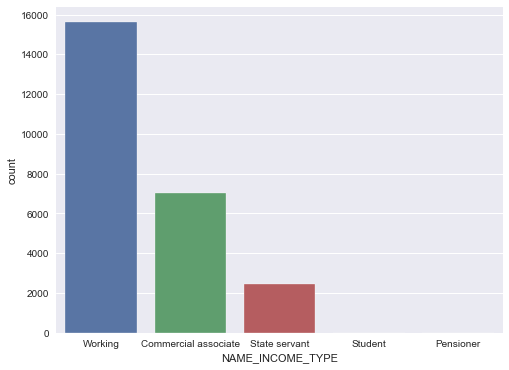

In [38]:
plt.figure(figsize=(8, 6)) 
sns.countplot(x=final_df['NAME_INCOME_TYPE'], data=final_df);

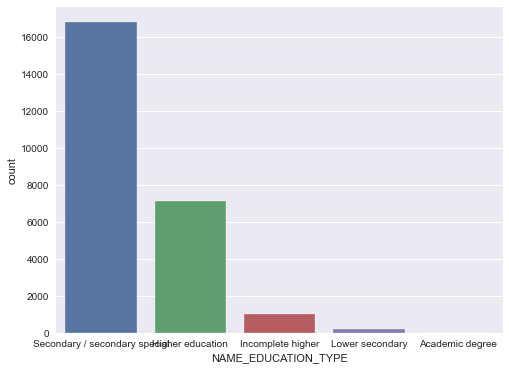

In [39]:
plt.figure(figsize=(8, 6)) 
sns.countplot(x=final_df['NAME_EDUCATION_TYPE'], data=final_df);

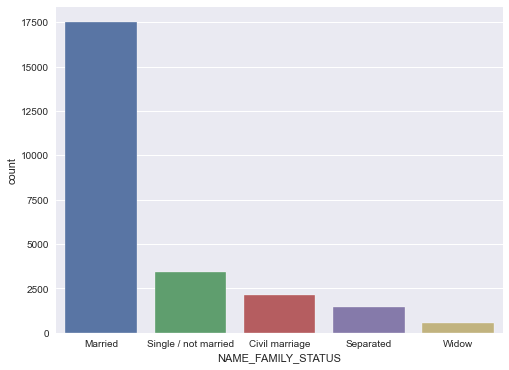

In [40]:
plt.figure(figsize=(8, 6)) 
sns.countplot(x=final_df['NAME_FAMILY_STATUS'], data=final_df);

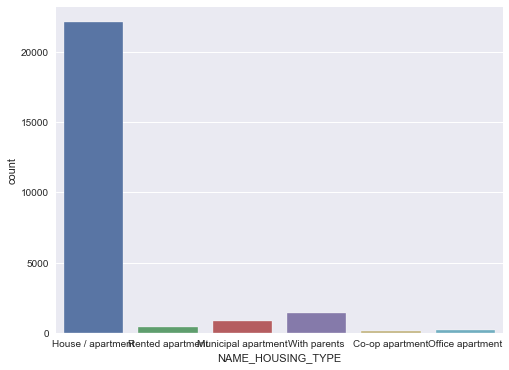

In [41]:
plt.figure(figsize=(8, 6)) 
sns.countplot(x=final_df['NAME_HOUSING_TYPE'], data=final_df);

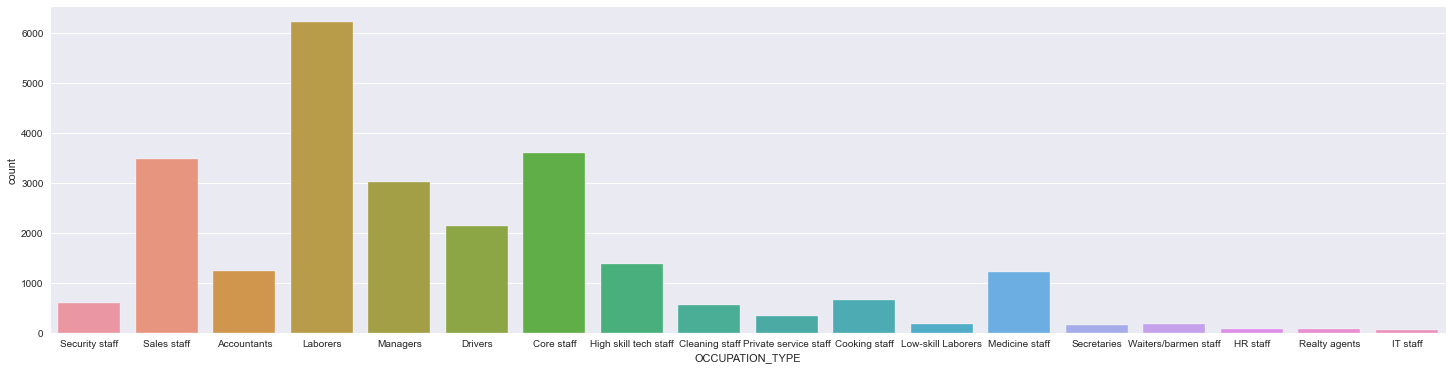

In [42]:
plt.figure(figsize=(25, 6))
sns.countplot(x=final_df['OCCUPATION_TYPE'], data=final_df);

Conclusion:
1. Top income type from potential approved customers are from the working class followed with commercial associate and state servant 
2. Top occupation as a Laborer followed by core staff
2. It is found that most of the potential approved customers are secondary / secondary special graduates (most likely are middle and high school graduates), followed by higher education and also those who are in higher education but didn't finish their school
3. Most customers family status are married followed by single/not married
4. Most of the customers are living in House/apartment (Owner) with age > 50

### Distribution & Outlier Check 

In [43]:
list(df_num)

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'MONTHS_BALANCE',
 'STATUS',
 'age',
 'years_employed',
 'CNT_CHILDREN']

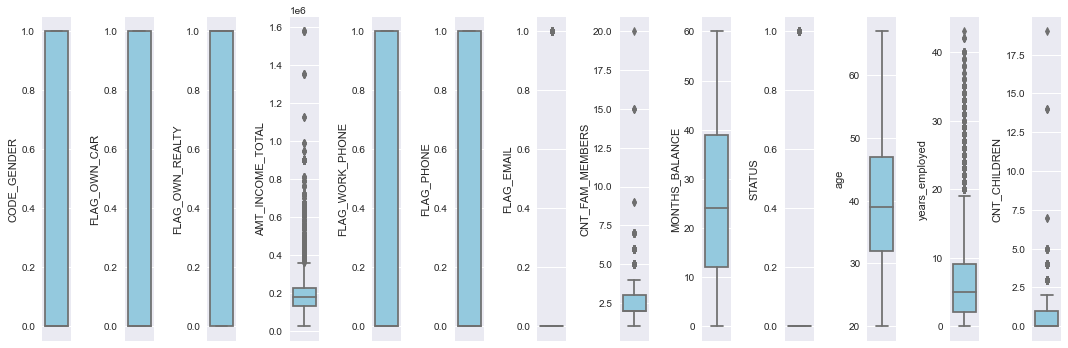

In [44]:
features = list(df_num)
plt.figure(figsize=(15,5))
for i in range(0, len (features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot (y=final_df[features[i]], color='skyblue')
    plt.tight_layout()

Handling Outlier with checking max value and decide whether it's still making sense or not

In [45]:
outlier = final_df['AMT_INCOME_TOTAL'].max()
outlier

1575000.0

In [46]:
outlier = final_df['FLAG_EMAIL'].max()
outlier

1

In [47]:
outlier = final_df['CNT_FAM_MEMBERS'].max()
outlier

20.0

In [48]:
outlier = final_df['STATUS'].max()
outlier

1

In [49]:
outlier = final_df['years_employed'].max()
outlier

43

In [50]:
outlier = final_df['CNT_CHILDREN'].max()
outlier

19

Hmm, 19 children in this era? Let's check

In [51]:
len(final_df.loc[final_df["CNT_CHILDREN"] == 19])

1

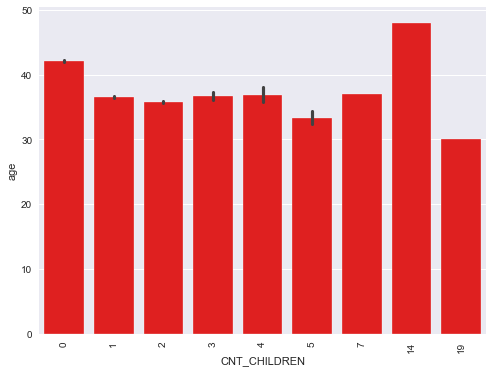

In [52]:
plt.figure(figsize=(8,6))

sns.barplot(data=final_df, x='CNT_CHILDREN', y='age', color='red')
plt.xticks(rotation=90);

After checking, it seems like these outliers are still okay to continue with

### KDE plot for knowing the distribution form

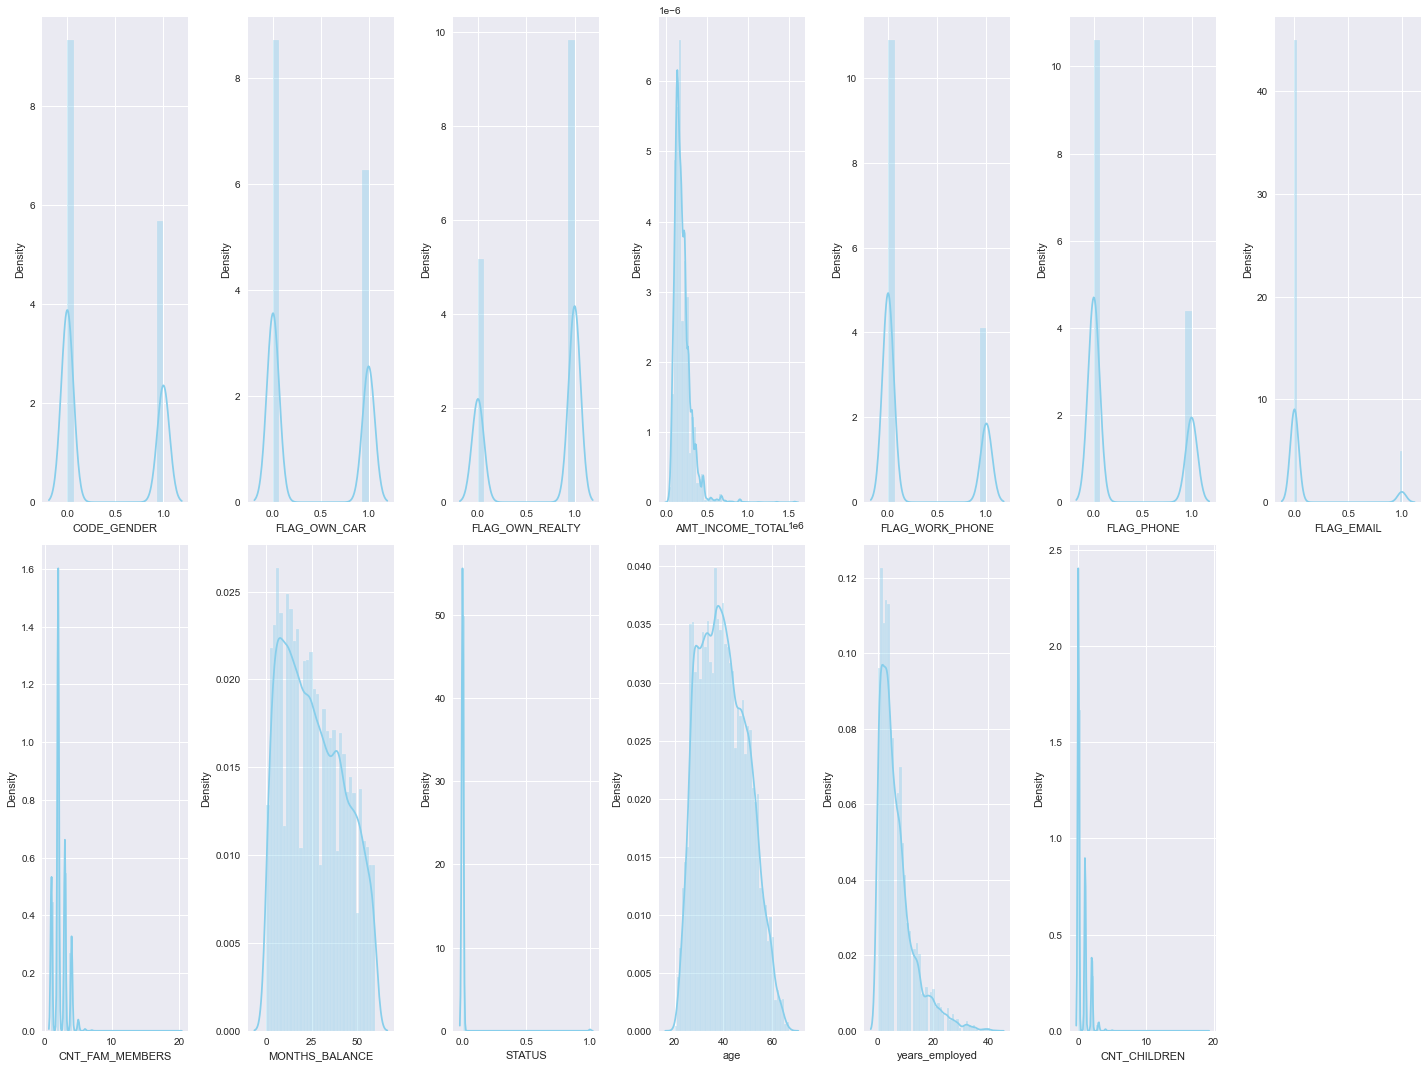

In [53]:
plt.figure(figsize=(20,15))

features = list(df_num)
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 1, i+1)
    #plt.subplot(1, len(features), i+1)
    sns.distplot(x=final_df[features[i]], color='skyblue')
    plt.xlabel(features[i])
    plt.tight_layout()

In [54]:
def distplot(feature, frame, color='b'):
    plt.figure(figsize=(8,3))
    plt.title("Distribution for {}".format(feature))
    ax = sns.distplot(frame[feature], color= color)

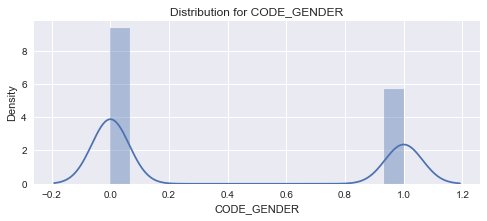

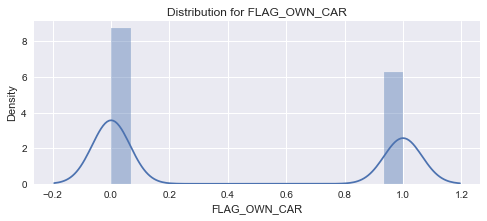

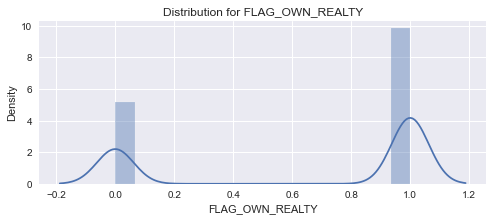

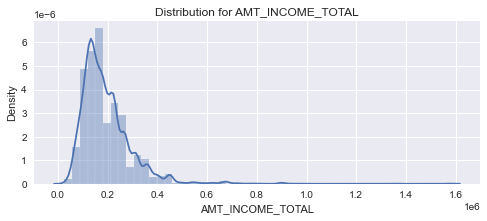

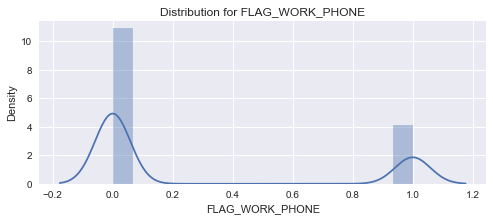

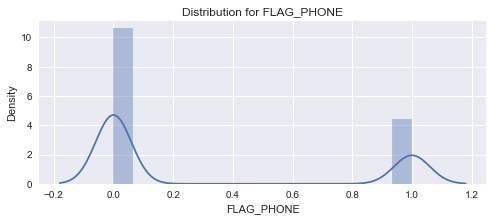

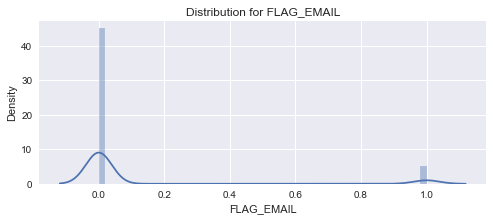

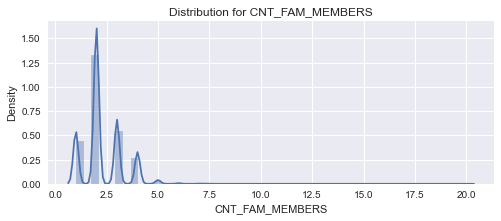

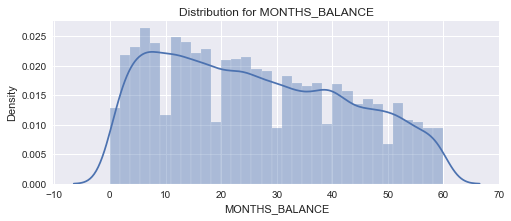

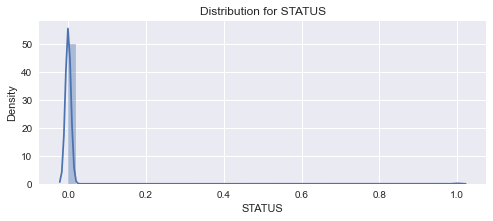

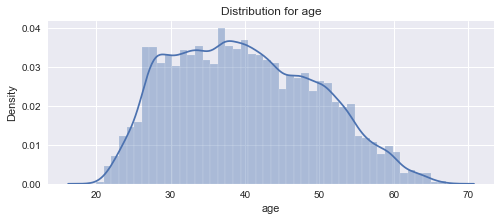

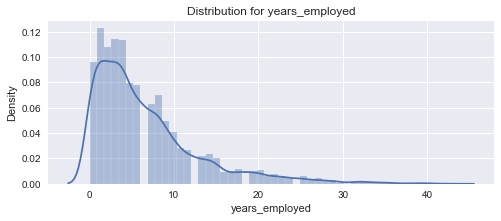

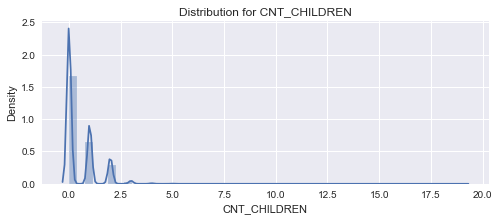

In [55]:
for feat in df_num: distplot(feat, df_num)

Insights:
1. Gender: Female > Male
2. Most of these people have work phone, some still don't but mostly yes
3. Top range for age is around 30-50 (Productive, working age)
4. Top years being employed range around 0-10


Some of the columns are positively skewed:
- AMT_INCOME_TOTAL
- age
- years employed
- MONTHS_BALANCE

The columns with boolean values are not positively skewed

<!-- When a column in a data set is positively skewed, it means that the data in that column has a tendency to lean towards the positive side of the scale, with more values on the higher end and fewer values on the lower end. In other words, the distribution of the data in the column is not symmetrical and has a longer tail towards the positive direction. This can result in a mean value that is higher than the median value, indicating a positive skew. -->

## Correlation Check

### Bivariate Analysis

In [56]:
final_df_cat

,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE
0,Working,Secondary / secondary special,Married,House / apartment,Security staff
1,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff
2,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff
3,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff
4,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff
...,...,...,...,...,...
25129,Working,Secondary / secondary special,Married,House / apartment,Managers
25130,Commercial associate,Higher education,Married,House / apartment,Medicine staff
25131,Pensioner,Higher education,Married,House / apartment,Medicine staff
25132,Working,Secondary / secondary special,Married,House / apartment,Sales staff


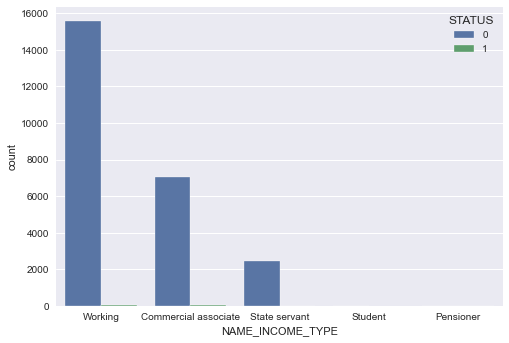

In [57]:
sns.countplot(data=final_df,
            hue='STATUS',
            x='NAME_INCOME_TYPE');

Good customers for income type are in the working type

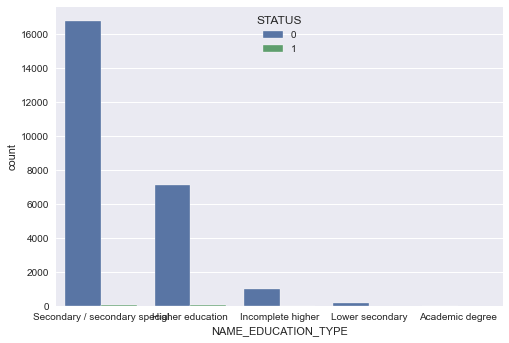

In [58]:
sns.countplot(data=final_df,
            hue='STATUS',
            x='NAME_EDUCATION_TYPE');

Good customers for education type are in the Secondary/secondary special

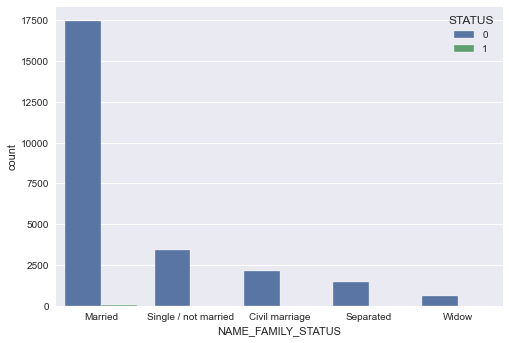

In [59]:
sns.countplot(data=final_df,
            hue='STATUS',
            x='NAME_FAMILY_STATUS');

Good customers for family status type are Married

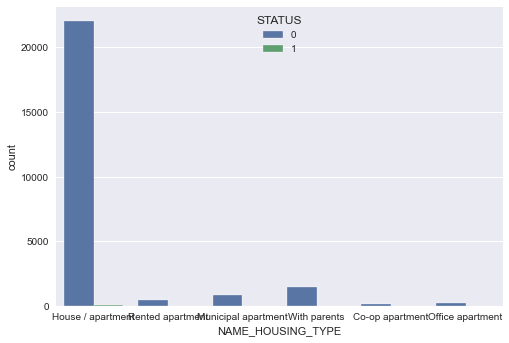

In [60]:
sns.countplot(data=final_df,
            hue='STATUS',
            x='NAME_HOUSING_TYPE');

For housing, good customers are most likely already have their own house/apartment followed by those who live with parents

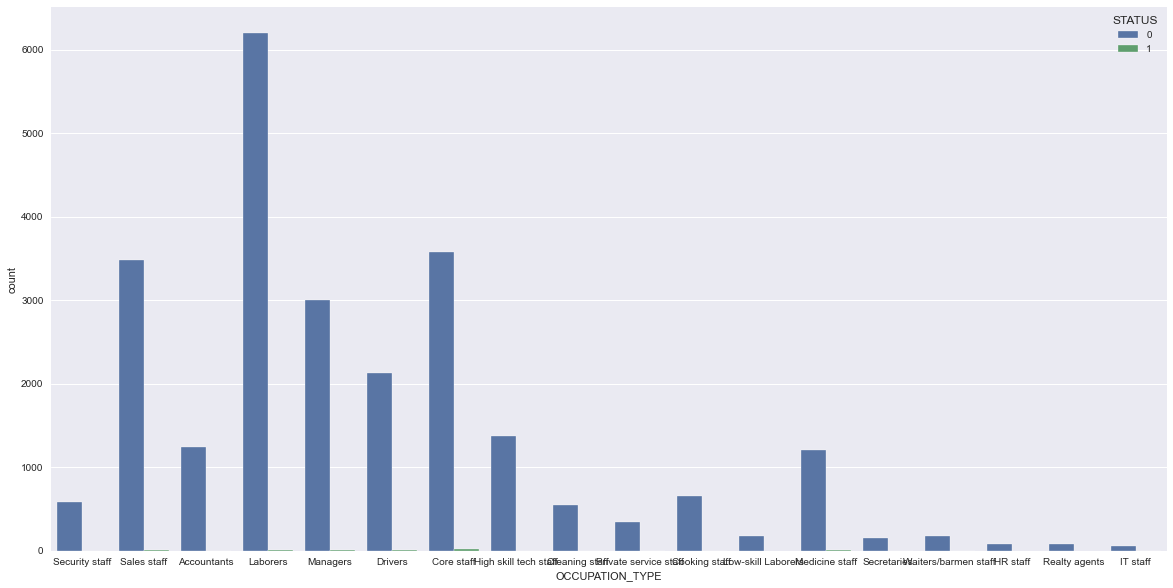

In [61]:
plt.figure(figsize=(20,10))
sns.countplot(data=final_df,
            hue='STATUS',
            x='OCCUPATION_TYPE');

Top good customers are workings as laborers followed by core staff, sales staff

### Good customers by gender

In [62]:
# Female = 0; Male = 1
final_df["STATUS"][final_df["STATUS"]==0].groupby(by=final_df["CODE_GENDER"]).count()

CODE_GENDER
0    15593
1     9467
Name: STATUS, dtype: int64

In [63]:
temp_df_stat_ok = final_df[['CODE_GENDER', 'STATUS']].copy()

temp_df_stat_ok = temp_df_stat_ok[temp_df_stat_ok['STATUS']==0]
temp_df_stat_ok
gender_ok = temp_df_stat_ok.sort_values(['CODE_GENDER'])
data_ok = (gender_ok
        .groupby('CODE_GENDER') 
        .agg(total=('STATUS','count'))
        .reset_index()
        .sort_values('total',ascending=True)
       )
data_ok

,CODE_GENDER,total
1,1,9467
0,0,15593


Since 0 is female, potential good customers are topped by female rather than male

In [64]:
# Female = 0; Male =1
final_df["STATUS"][final_df["STATUS"]==0].groupby(by=final_df["NAME_INCOME_TYPE"]).count()

NAME_INCOME_TYPE
Commercial associate     7033
Pensioner                   9
State servant            2432
Student                    10
Working                 15576
Name: STATUS, dtype: int64

In [65]:
temp_df_stat_ok = final_df[['NAME_INCOME_TYPE', 'STATUS']].copy()

temp_df_stat_ok = temp_df_stat_ok[temp_df_stat_ok['STATUS']==0]
temp_df_stat_ok
gender_ok = temp_df_stat_ok.sort_values(['NAME_INCOME_TYPE'])
data_ok = (gender_ok
        .groupby('NAME_INCOME_TYPE') 
        .agg(total=('STATUS','count'))
        .reset_index()
        .sort_values('total',ascending=True)
       )

data_ok

,NAME_INCOME_TYPE,total
1,Pensioner,9
3,Student,10
2,State servant,2432
0,Commercial associate,7033
4,Working,15576


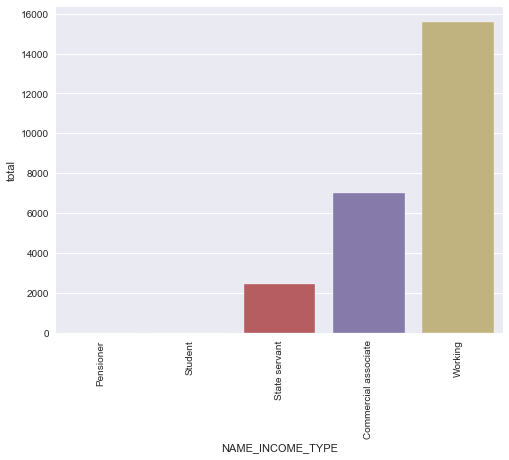

In [66]:
# visualize it
plt.figure(figsize=(8,6))

sns.barplot(data=data_ok, x='NAME_INCOME_TYPE', y='total')
plt.xticks(rotation=90);

In [67]:
# final_df['NAME_INCOME_TYPE' == 'Working']

final_df[final_df['NAME_INCOME_TYPE'] == 'Working'].head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS,MONTHS_BALANCE,age,years_employed
0,5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,0,29,58,3
5,5008815,1,1,1,0,270000.0,Working,Higher education,Married,House / apartment,1,1,1,Accountants,2.0,0,5,46,2
6,5112956,1,1,1,0,270000.0,Working,Higher education,Married,House / apartment,1,1,1,Accountants,2.0,0,42,46,2
13,5008825,0,1,0,0,130500.0,Working,Incomplete higher,Married,House / apartment,0,0,0,Accountants,2.0,0,25,29,3
14,5008826,0,1,0,0,130500.0,Working,Incomplete higher,Married,House / apartment,0,0,0,Accountants,2.0,0,30,29,3


Top potential good customers are from the working class followed by commercial associate

### Heat Map Correlation

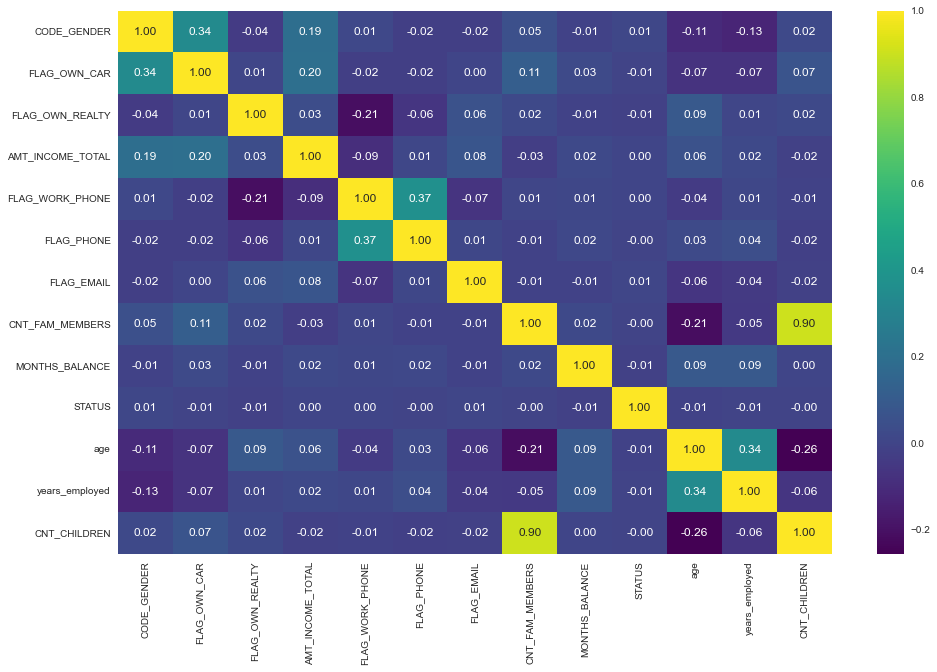

In [68]:
corr_= df_num.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "viridis");

1. `CNT_FAM_MEMBERS` and `CNT_CHILDREN` are highly correlated to each other, with **0.90** point.
2.  Our threshold is at least 0.8, so we will drop one of the column so it won't make the feature redundant.
3.  We will drop `CNT_CHILDREN`.

In [69]:
# final_df = final_df.drop("CNT_CHILDREN", axis=1)
df_num = df_num.drop("CNT_CHILDREN", axis=1)

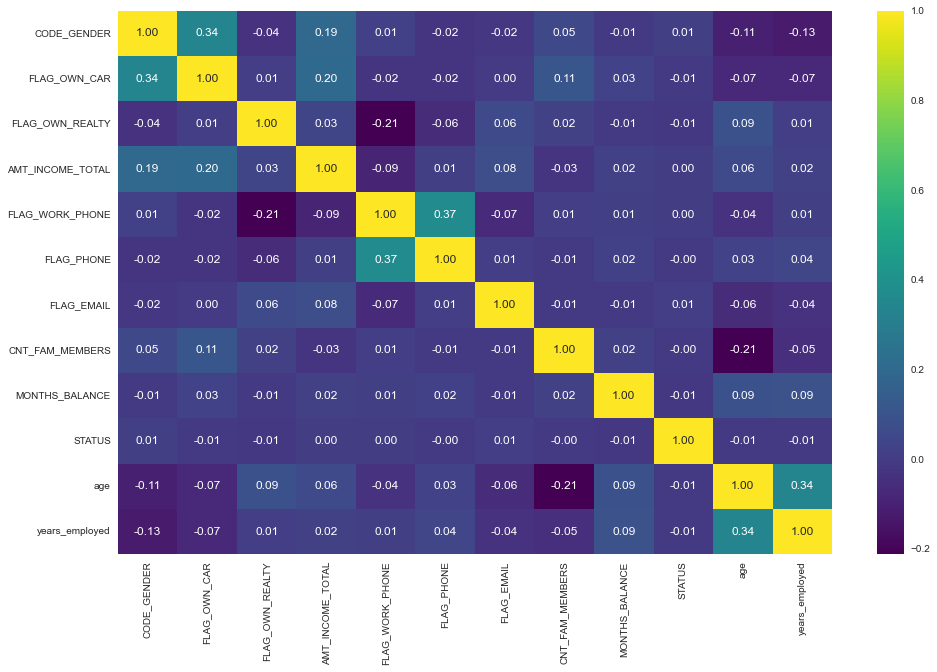

In [70]:
corr_= df_num.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "viridis");

So far the correlation is pretty good

# Modeling

Our dataset is imbalance, because we can see that label GOOD (0) is way less than label 1 (potentially NOT GOOD).

Recall/Sensitivity is an appropriate metric when a false negative event is most wanted to be avoided (high risk).

False Negative = When we predict the customers aren't bad, but they really are.

If we want to detect Good customer so that we can do some actions to prevent it, we have to use Recall as our metric.

And in this case We better predict the customers that are good, but the customers aren't. So when we want to reach out to the customers that will likely be in the good group, we will do some action to prevent it. And even if the customers aren't actually good, that's not a bad thing.

False Positive = When we predict the customers are good, but the customers actually aren't.

### Check Imbalanced

In [71]:
df_num['STATUS'].value_counts()

0    25060
1       74
Name: STATUS, dtype: int64

# Random Forest

In [72]:
# the usual splitting 
from sklearn.model_selection import train_test_split
from imblearn import under_sampling
from imblearn.under_sampling import RandomUnderSampler

X_rf = df_num.drop(columns='STATUS').to_numpy()
y_rf = df_num[['STATUS']].to_numpy()
y_rf = y_rf.reshape(len(y_rf),)

X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, test_size=0.20, random_state=42)

# Undersampling
X_rf_train_under, y_rf_train_under = under_sampling.RandomUnderSampler().fit_resample(X_rf_train, y_rf_train)

In [73]:
# define random forest classifier model
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)

In [74]:
%%time
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': (10,20,30,40,50),
    'max_depth':(1,2,3,4,5)
}

# note: we use recall
rf_clf_gridcv = GridSearchCV(rf_clf, parameters, cv=5, scoring='accuracy')
rf_clf_gridcv.fit(X_rf_train_under, y_rf_train_under)

CPU times: total: 6.83 s
Wall time: 6.87 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': (1, 2, 3, 4, 5),
                         'n_estimators': (10, 20, 30, 40, 50)},
             scoring='accuracy')

In [75]:
# the results
cv_result = pd.DataFrame(rf_clf_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
18,"{'max_depth': 4, 'n_estimators': 40}",0.564615,1
24,"{'max_depth': 5, 'n_estimators': 50}",0.556923,2
22,"{'max_depth': 5, 'n_estimators': 30}",0.556923,2
17,"{'max_depth': 4, 'n_estimators': 30}",0.549231,4
12,"{'max_depth': 3, 'n_estimators': 30}",0.548923,5
19,"{'max_depth': 4, 'n_estimators': 50}",0.548308,6
21,"{'max_depth': 5, 'n_estimators': 20}",0.540923,7
20,"{'max_depth': 5, 'n_estimators': 10}",0.533231,8
16,"{'max_depth': 4, 'n_estimators': 20}",0.532923,9
23,"{'max_depth': 5, 'n_estimators': 40}",0.524923,10


If we want to speed up the training process, we may use RandomizedSearchCV

In [76]:
%%time
# using random search CV
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'n_estimators': (10,20,30,40,50),
    'max_depth':(1,2,3,4,5)
}

rf_clf_randomcv = RandomizedSearchCV(rf_clf, parameters, cv=5, 
                                     scoring='accuracy', n_iter=10)
rf_clf_randomcv.fit(X_rf_train_under, y_rf_train_under)

CPU times: total: 2.08 s
Wall time: 2.08 s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': (1, 2, 3, 4, 5),
                                        'n_estimators': (10, 20, 30, 40, 50)},
                   scoring='accuracy')

Now it only takes slightly less seconds (compared to >7 seconds when using the full GridSearchCV)

In [77]:
# results of RandomSearchCV
cv_result = pd.DataFrame(rf_clf_randomcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
6,"{'n_estimators': 30, 'max_depth': 3}",0.548923,1
7,"{'n_estimators': 10, 'max_depth': 5}",0.533231,2
5,"{'n_estimators': 20, 'max_depth': 4}",0.532923,3
3,"{'n_estimators': 30, 'max_depth': 2}",0.517231,4
4,"{'n_estimators': 20, 'max_depth': 2}",0.501538,5
9,"{'n_estimators': 40, 'max_depth': 3}",0.501538,5
0,"{'n_estimators': 30, 'max_depth': 1}",0.485231,7
8,"{'n_estimators': 10, 'max_depth': 1}",0.484923,8
1,"{'n_estimators': 20, 'max_depth': 1}",0.477231,9
2,"{'n_estimators': 10, 'max_depth': 4}",0.469846,10


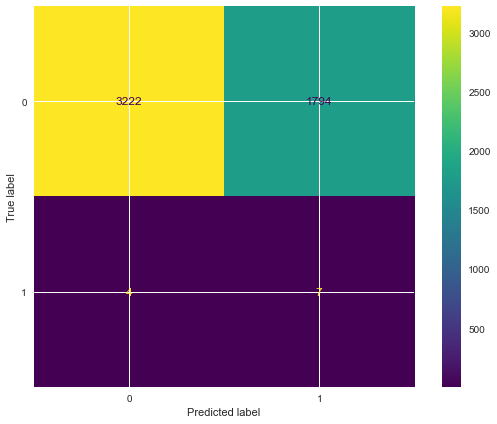

In [78]:
# the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_rf_pred = rf_clf_randomcv.best_estimator_.predict(X_rf_test)

cm = confusion_matrix(y_rf_test, y_rf_pred, labels=rf_clf_randomcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf_clf_randomcv.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

In [79]:
# classification report
from sklearn.metrics import classification_report
y_rf_pred = rf_clf_gridcv.best_estimator_.predict(X_rf_test)
print(classification_report(y_rf_test, y_rf_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80      5016
           1       0.00      0.64      0.01        11

    accuracy                           0.67      5027
   macro avg       0.50      0.65      0.40      5027
weighted avg       1.00      0.67      0.80      5027



In [80]:
import numpy as np
from sklearn.metrics import f1_score

#calculate F1 score
f1_score(y_rf_test, y_rf_pred)

0.00834326579261025

In [81]:
import numpy as np
from sklearn.metrics import accuracy_score

#calculate accuracy score
accuracy_score(y_rf_test, y_rf_pred)

0.6689874676745574

# K-NN Classification

In [82]:
# split the data 
from sklearn.model_selection import train_test_split

X_knn = df_num.drop(columns='STATUS').to_numpy()
y_knn = df_num[['STATUS']].to_numpy()
y_knn = y_knn.reshape(len(y_knn),)

X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(X_knn, y_knn, test_size=0.20, random_state=42)

# Undersampling
X_knn_train_under, y_knn_train_under = under_sampling.RandomUnderSampler().fit_resample(X_knn_train, y_knn_train)

In [83]:
# It's important to choose the right metric when doing classification
df_num['STATUS'].value_counts()

0    25060
1       74
Name: STATUS, dtype: int64

The class distribution is IMBALANCE, so need NOT to use `accuracy`. Use `recall` (sensitivity) instead

In [84]:
# define the estimator/model
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

In [85]:
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_neighbors': (2,3,4,5,6,7,8)
}

knn_clf_gridcv = GridSearchCV(knn_clf, parameters, cv=5, scoring='precision')
knn_clf_gridcv.fit(X_knn_train_under, y_knn_train_under)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': (2, 3, 4, 5, 6, 7, 8)},
             scoring='precision')

In [86]:
# the compact results
cv_result = pd.DataFrame(knn_clf_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols]

,params,mean_test_score,rank_test_score
0,{'n_neighbors': 2},0.525108,3
1,{'n_neighbors': 3},0.513045,4
2,{'n_neighbors': 4},0.498456,6
3,{'n_neighbors': 5},0.498562,5
4,{'n_neighbors': 6},0.536905,1
5,{'n_neighbors': 7},0.534093,2
6,{'n_neighbors': 8},0.476667,7


In [87]:
# what if we also want to tune "weights" hyperparameter
# "uniform": all K neighbors have the same influence
# "distance": closer neighbor in those K neighbors has stronger influence
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_neighbors': (2,3,4,5,6,7,8),
    'weights':('uniform','distance')
}

# now we use recall (sensitivity) as metric
knn_clf_gridcv = GridSearchCV(knn_clf, parameters, cv=5, scoring='precision')
knn_clf_gridcv.fit(X_knn_train_under, y_knn_train_under)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': (2, 3, 4, 5, 6, 7, 8),
                         'weights': ('uniform', 'distance')},
             scoring='precision')

In [88]:
# the results
cv_result = pd.DataFrame(knn_clf_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
11,"{'n_neighbors': 7, 'weights': 'distance'}",0.553696,1
7,"{'n_neighbors': 5, 'weights': 'distance'}",0.544444,2
13,"{'n_neighbors': 8, 'weights': 'distance'}",0.540409,3
8,"{'n_neighbors': 6, 'weights': 'uniform'}",0.536905,4
10,"{'n_neighbors': 7, 'weights': 'uniform'}",0.534093,5
1,"{'n_neighbors': 2, 'weights': 'distance'}",0.533664,6
3,"{'n_neighbors': 3, 'weights': 'distance'}",0.529924,7
0,"{'n_neighbors': 2, 'weights': 'uniform'}",0.525108,8
2,"{'n_neighbors': 3, 'weights': 'uniform'}",0.513045,9
9,"{'n_neighbors': 6, 'weights': 'distance'}",0.512494,10


### Evaluation metrics on test data

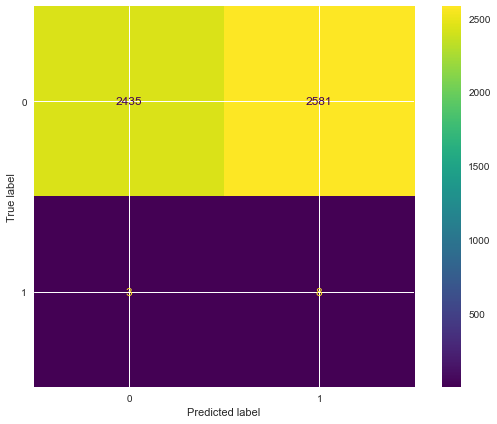

In [89]:
# plotting confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_knn_pred = knn_clf_gridcv.best_estimator_.predict(X_knn_test)

cm = confusion_matrix(y_knn_test, y_knn_pred, labels=knn_clf_gridcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=knn_clf_gridcv.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

In [90]:
# classification report
from sklearn.metrics import classification_report
y_knn_pred = knn_clf_gridcv.best_estimator_.predict(X_knn_test)
print(classification_report(y_knn_test, y_knn_pred))

              precision    recall  f1-score   support

           0       1.00      0.49      0.65      5016
           1       0.00      0.73      0.01        11

    accuracy                           0.49      5027
   macro avg       0.50      0.61      0.33      5027
weighted avg       1.00      0.49      0.65      5027



In [91]:
import numpy as np
from sklearn.metrics import f1_score

#calculate F1 score
f1_score(y_knn_test, y_knn_pred)

0.006153846153846154

In [92]:
import numpy as np
from sklearn.metrics import accuracy_score

#calculate accuracy score
accuracy_score(y_knn_test, y_knn_pred)

0.4859757310523175

In [93]:
# calculate AUC
print('AUC ',roc_auc_score(y_knn_test, y_knn_pred))

AUC  0.606359649122807


In [94]:
# calculate F1 Score
print('F1 Score ',f1_score(y_knn_test, y_knn_pred))

F1 Score  0.006153846153846154


TIP: Just focus on the row '1'.
<br>

### Conclusion (Model)

Model digunakan:

1. Random Forest
2. KNN

- Ada perbedaan yaitu pada Random Forest dihasilkan Precision = 0.60 (60%)
- Pada KNN Precision = 0.78 (78%)

Maka didapatkan kesimpulan bahwa KNN adalah model terbaik untuk dataset Credit Card Approval Prediction

### Feature Importance (KNN)

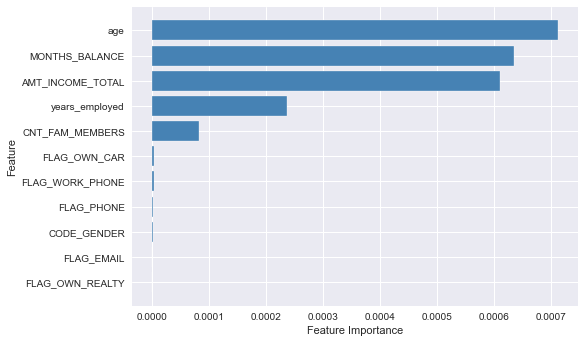

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate permutation feature importance scores
perm_importance = permutation_importance(knn_clf_gridcv, X_knn_test, y_knn_test, n_repeats=10, random_state=0)

# Get the feature names
X_knn = df_num.drop(columns='STATUS')
# y_knn = df_num[['STATUS']].to_numpy()
feature_names = X_knn.columns

# Sort the feature importance scores in descending order
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

# Reverse the order of the feature importance scores and feature names
perm_importance.importances_mean = perm_importance.importances_mean[sorted_idx][::-1]
feature_names = feature_names[sorted_idx][::-1]

# Plot the feature importance scores
plt.barh(range(X_knn.shape[1]), perm_importance.importances_mean, color='steelblue')
plt.yticks(range(X_knn.shape[1]), feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()